### EDA and Feature Selection

In [105]:
#All imports we'll need in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

In [31]:
data = pd.read_csv('more_data_fixed.csv')

Check how many data points that we scraped have an aggregate user score listed

In [4]:
len(data[data.user_score != 'tbd'])

1331

We have 1331 data points out of 2503 without user scores (all albums have critic score).  For now, I am going to stick with critic score as my only target variable so that I can leverage the larger dataset.

In [24]:
data.describe()

It doesn't look right that an artist would have 0 monthly listeners.  Since this was only 4 rows, I just dropped them.

In [6]:
data.drop(columns=['Unnamed: 0', 'user_score'], inplace=True)
data = data[data.artist_monthly_listeners > 0]
data.reset_index(drop=True,inplace=True)

- We can see that users are more likely to give very harsh scores than critics anywhere from 20-55
- Critics are more likely to hand out scores from 55-75
- Users are slightly more likely to hand out positive scores from 75-90
- Critics are more likely to give out "perfect" scores from 90-100

For well known, critically acclaimed albums, there are way more users rating the album, so it is more difficult
to achieve a consensus that is higher than a 90/100.  For example, metacritic's top album of the year, Fiona Apple's
Fetch the Bolt Cutters, has a 98 critic score on 28 critic reviews as opposed to an 81 user score on 1,076 reviews

In [10]:
labels = data['critic_score']
features = data[['critic_score','release_month','day_of_week_release', 'num_tracks', 'artist_monthly_listeners', \
                       'album_length_seconds', 'avg_track_length_seconds', 'percent_explicit', 'danceability_avg', \
                      'energy_avg', 'loudness_avg', 'speechiness_avg', 'acousticness_avg', 'instrumentalness_avg', \
                      'liveness_avg', 'valence_avg', 'tempo_avg']]


I'm leaving the critic and user score in my features list for now so that they are included when I look at distributions, pairplots, etc.

Normally I would separate my data here into train and test sets before exploring the data any further, to prevent any data snooping bias.  Along the way, I decided I wanted to stratify my split data by a specific column, so I re-ran the train/test split after creating that column.  But here is the train/test code for reference:

In [ ]:
# from sklearn.model_selection import StratifiedShuffleSplit
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# for train_index, test_index in sss.split(features, features['explicit_cat']):
#     strat_train_set = features.loc[train_index]
#     strat_test_set = features.loc[test_index]

Check for any more null values and then plot histograms of our features and target to visualize distributions

In [11]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   critic_score              2499 non-null   int64  
 1   release_month             2499 non-null   int64  
 2   day_of_week_release       2499 non-null   int64  
 3   num_tracks                2499 non-null   int64  
 4   artist_monthly_listeners  2499 non-null   int64  
 5   album_length_seconds      2499 non-null   float64
 6   avg_track_length_seconds  2499 non-null   float64
 7   percent_explicit          2499 non-null   float64
 8   danceability_avg          2499 non-null   float64
 9   energy_avg                2499 non-null   float64
 10  loudness_avg              2499 non-null   float64
 11  speechiness_avg           2499 non-null   float64
 12  acousticness_avg          2499 non-null   float64
 13  instrumentalness_avg      2499 non-null   float64
 14  liveness

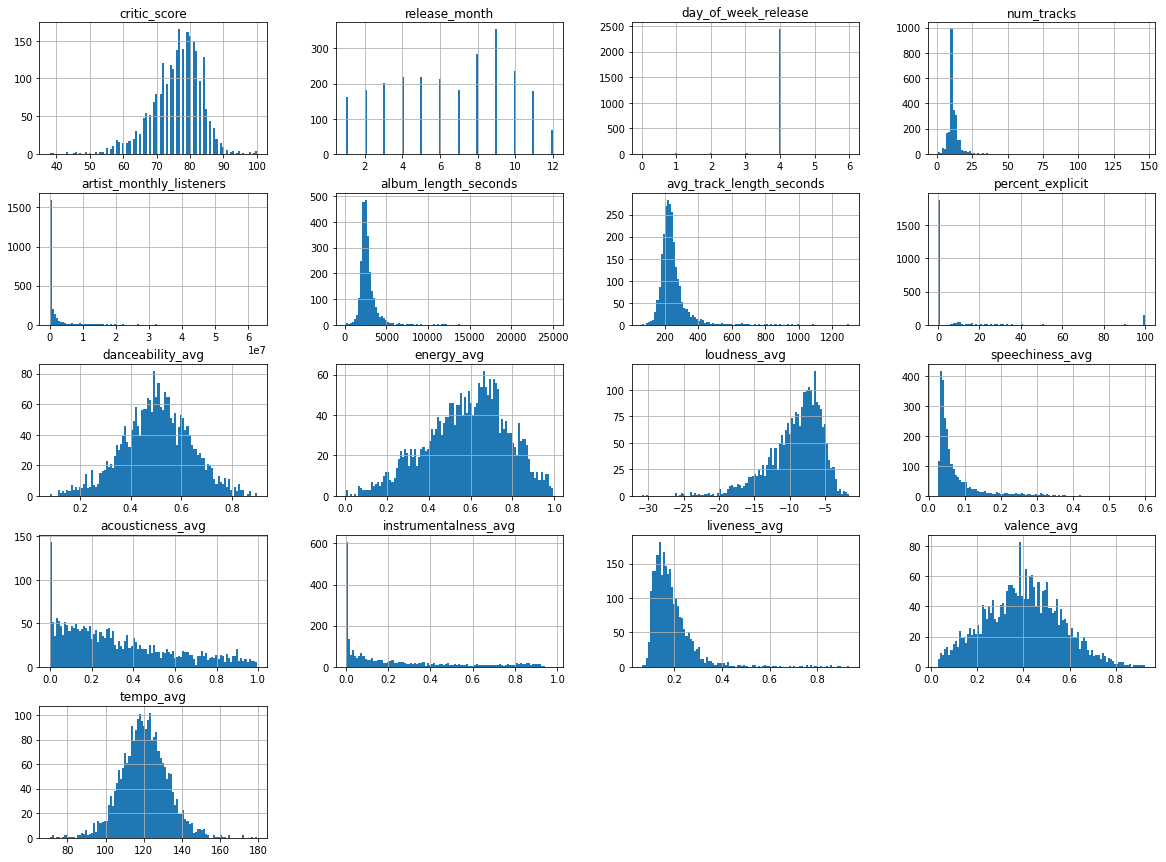

In [12]:
%matplotlib inline
features.hist(bins=100, figsize=(20,15))
plt.show()

A few takeaways from glancing at these distributions:
- Our target variable has a slight left skew, and it looks like critic scores rarely dip below 50
- Artist monthly listeners and instrumentalness are both heavily right skewed (specifically, a lot of albums seem to be at exactly zero for average instrumentalness).  This means that most of the artists on metacritic are ones who haven't "made it" yet in the industry, and most albums have vocals throughout, or if not then they may have short instrumental interludes 
- Almost all albums are released on Fridays, so that feature will likely not be helpful to us
- Based on the fact that most albums are either 0% or 100% explicit, it might make sense to treat this as a categorical variable with 3 bins (None explicit, some explicit, and all explicit)

- Not a lot of music is released in December during the holiday season.  August, September, and October are the three busiest months though, which makes sense intuitively: big artists on major labels want to take advantage of the holiday retail spike, many artists want to be in contention for end of year lists and awards show nominations (for example, the cutoff for Grammy eligibility is Sept. 30th). Interesting data, but unclear how it might affect our regression- we could look at August-October as one "group" to see if critic scores change when the writers are busier, or if albums released in December tend to be underappreciated as writers focus on their "Best Of" lists.

### Let's zoom in on some of these distributions to highlight these takeaways

In theory the critic score can range from 0 to 100, but considering that album metascores are an aggregate of all critic reviews, no album scores less than a 38:

In [13]:
features.critic_score.min()

38

Plot distribution of our target variable:

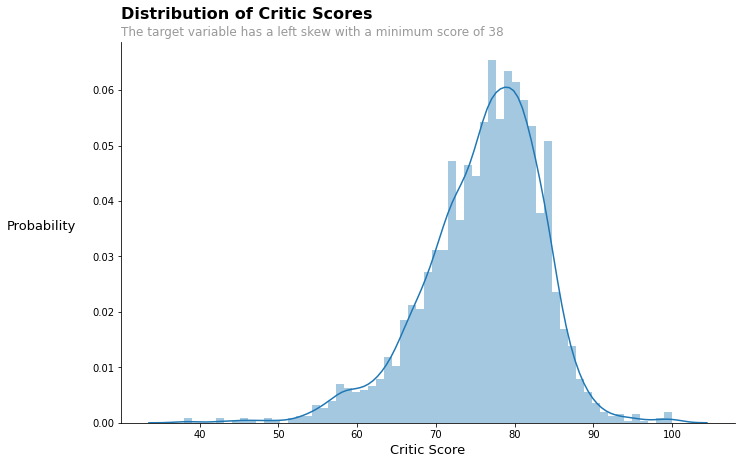

In [14]:
fig, ax = plt.subplots(figsize=(11,7))
sns.distplot(features.critic_score, bins=61)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Probability',fontsize=13, rotation='horizontal', labelpad=50)
ax.set_xlabel('Critic Score', fontsize=13)
ax.set_title('The target variable has a left skew with a minimum score of 38',loc='left', color="#999999")
fig.suptitle('Distribution of Critic Scores', x=0.125, y=.95, ha='left', fontsize=16,fontweight='semibold');

Plot the distribution of days of the week on which albums are released:

Since the vast majority of albums are released on Fridays, it doesn't really make sense to use the day of the week as a feature for our model.

Text(0.0, 1.0, "Since day of week doesn't vary enough, I removed it from feature set")

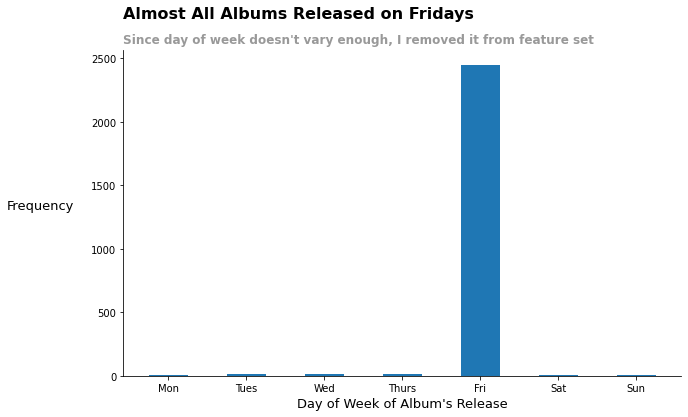

In [15]:
fig,ax=plt.subplots(figsize=(10,6))
ax.hist(features.day_of_week_release, bins=[0, 1, 2, 3, 4, 5, 6, 7], rwidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Day of Week of Album\'s Release', fontsize=13)
ax.set_ylabel('Frequency', fontsize=13, rotation='horizontal', labelpad=50)
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
fig.suptitle('Almost All Albums Released on Fridays', x=0.125, ha='left', fontsize=16,fontweight='semibold')
ax.set_title('Since day of week doesn\'t vary enough, I removed it from feature set', loc='left', color="#999999", fontweight='bold')


Plot the distribution of album explictness % to visualize the 3 "categories" of: 
- 0% explicit
- Some explicit (1-99%)
- 100% explicit

Text(0.0, 1.0, 'The explicitness feature might work better as a categorical variable')

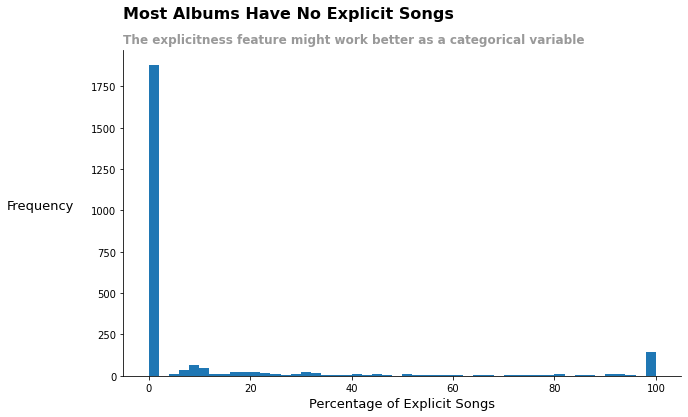

In [18]:
fig,ax=plt.subplots(figsize=(10,6))
ax.hist(features.percent_explicit, bins=50)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Percentage of Explicit Songs', fontsize=13)
ax.set_ylabel('Frequency', fontsize=13, rotation='horizontal', labelpad=50)
fig.suptitle('Most Albums Have No Explicit Songs', x=0.125, ha='left', fontsize=16,fontweight='semibold')
ax.set_title('The explicitness feature might work better as a categorical variable', loc='left', color="#999999", fontweight='bold')

In [28]:
features['explicit_cat'] = features['percent_explicit'].apply(lambda x: 1 if ((x > 0) & (x<100)) else x)
features['explicit_cat'] = features['explicit_cat'].apply(lambda x: 2 if x > 1 else x)

In [39]:
print(features[features.explicit_cat == 0]['critic_score'].mean())
print(features[features.explicit_cat == 1]['critic_score'].mean())
print(features[features.explicit_cat == 2]['critic_score'].mean())

76.37732836615221
75.56962025316456
73.4931506849315


Plot the distribution of monthly listeners to show heavy right skew:

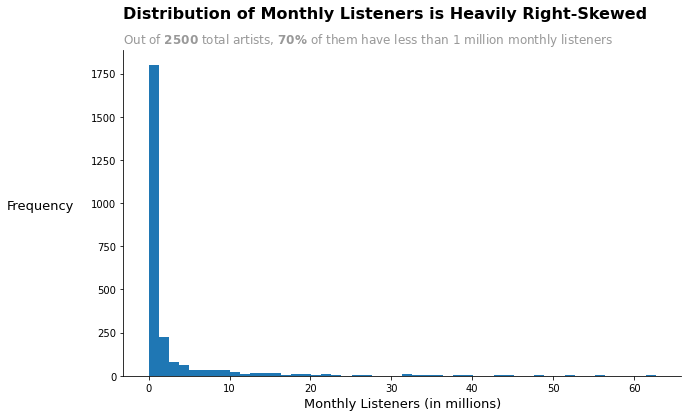

In [20]:
fig,ax=plt.subplots(figsize=(10,6))
ax.hist(features.artist_monthly_listeners, bins=50);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 10000000, 20000000, 30000000, 40000000, 50000000, 60000000])
ax.set_xticklabels([0, 10, 20, 30, 40, 50, 60])
ax.set_xlabel('Monthly Listeners (in millions)', fontsize=13)
ax.set_ylabel('Frequency', fontsize=13, rotation='horizontal', labelpad=50)
fig.suptitle('Distribution of Monthly Listeners is Heavily Right-Skewed', x=0.125, ha='left', fontsize=16,fontweight='semibold')
ax.set_title('Out of ' + r"$\bf{" + '2500' + "}$" + ' total artists, ' + r"$\bf" + "70\%" + "}$" + ' of them have less than 1 million monthly listeners',loc='left', color="#999999");


Plot the log transform of this feature to show the new distribution:

/Users/vinnythompson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


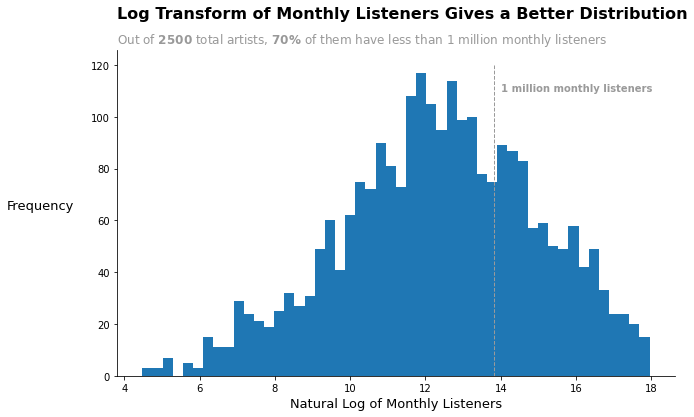

In [22]:
features['log_monthly_listeners'] = np.log(features['artist_monthly_listeners'])

fig,ax=plt.subplots(figsize=(10,6))
ax.hist(features.log_monthly_listeners, bins=50);
ax.plot([13.815, 13.815], [0, 120], color = "#9a9a9a", linestyle='--', linewidth=1)
ax.annotate('1 million monthly listeners', xy=[13.815, 120], xytext=[14, 110], color="#9a9a9a", fontweight='semibold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Natural Log of Monthly Listeners', fontsize=13)
ax.set_ylabel('Frequency', fontsize=13, rotation='horizontal', labelpad=50)
fig.suptitle('Log Transform of Monthly Listeners Gives a Better Distribution', x=0.125, ha='left', fontsize=16,fontweight='semibold')
ax.set_title('Out of ' + r"$\bf{" + '2500' + "}$" + ' total artists, ' + r"$\bf" + "70\%" + "}$" + ' of them have less than 1 million monthly listeners',loc='left', color="#999999");


### Next, let's look at correlations to start to get an idea of feature importance, and identify any potential multicollinearity

Text(0.0, 1.0, 'No features have a correlation magnitude of > .20 with our target')

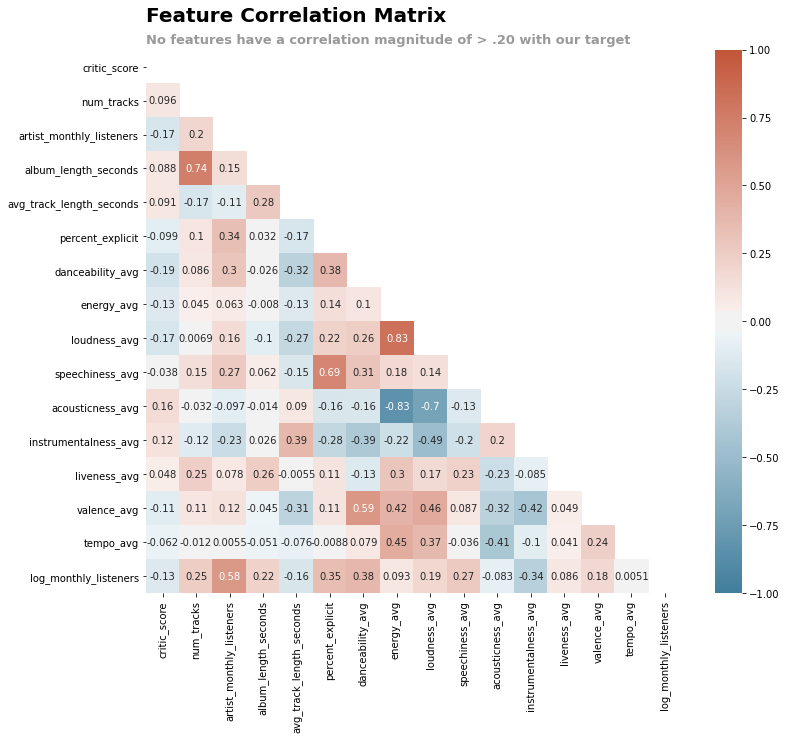

In [25]:
fig, ax = plt.subplots(figsize=(12,10))
corr = features.drop(columns=['release_month', 'day_of_week_release']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap=sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(data=corr, mask=mask, vmin = -1, vmax = 1, cmap=cmap, annot=True);
fig.suptitle('Feature Correlation Matrix', fontsize=20, x = .125, y = .94, ha='left', fontweight='bold')
ax.set_title('No features have a correlation magnitude of > .20 with our target', fontsize=13, color="#999999", fontweight='bold', loc='left');

At first glance it looks like none of our features are strongly correlated with our target, so  some feature engineering or polynomial/interaction features may be necessary.  

It also looks like there are some larger magnitudes in the region of the matrix with Spotify's audio features.  Let's zoom in on those correlations:

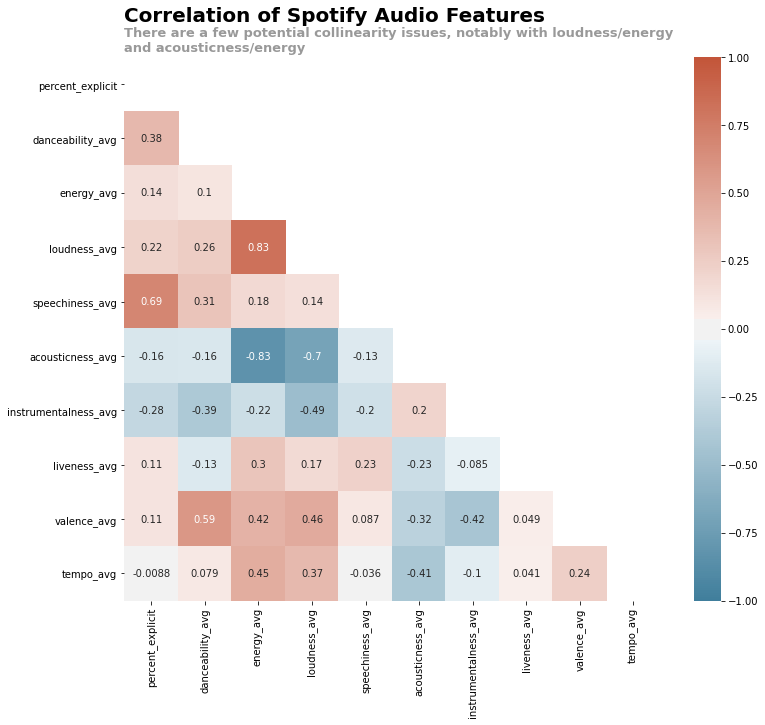

In [26]:
fig, ax = plt.subplots(figsize=(12,10))
corr = features.drop(columns=['release_month', 'day_of_week_release', 'critic_score', \
                             'num_tracks', 'artist_monthly_listeners', 'album_length_seconds', \
                             'avg_track_length_seconds', 'log_monthly_listeners']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap=sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(data=corr, mask=mask, vmin = -1, vmax = 1, cmap=cmap, annot=True);
fig.suptitle('Correlation of Spotify Audio Features', fontsize=20, x = .125, y = .95, ha='left', fontweight='bold')
ax.set_title('There are a few potential collinearity issues, notably with loudness/energy \nand acousticness/energy', fontsize=13, color="#999999", fontweight='bold', loc='left')
plt.savefig('audio_features_correlation.png')

- danceability and valence (a measure of how happy the music is) are positively correlated
- loudness and energy are positively correlated
- energy and speechiness have an interesting correlation, where there seem to be two separate branches.  I'm curious if this indicates two different "categories" that follow different trends
- energy and loudness are both negatively correlated with acousticness

Due to some of these correlations, I ended up making the decision to drop the following columns from my final model:
- Energy Avg.
- Valence Avg.
- Tempo Avg.

A pairplot is also provided for another look at some of these correlations:

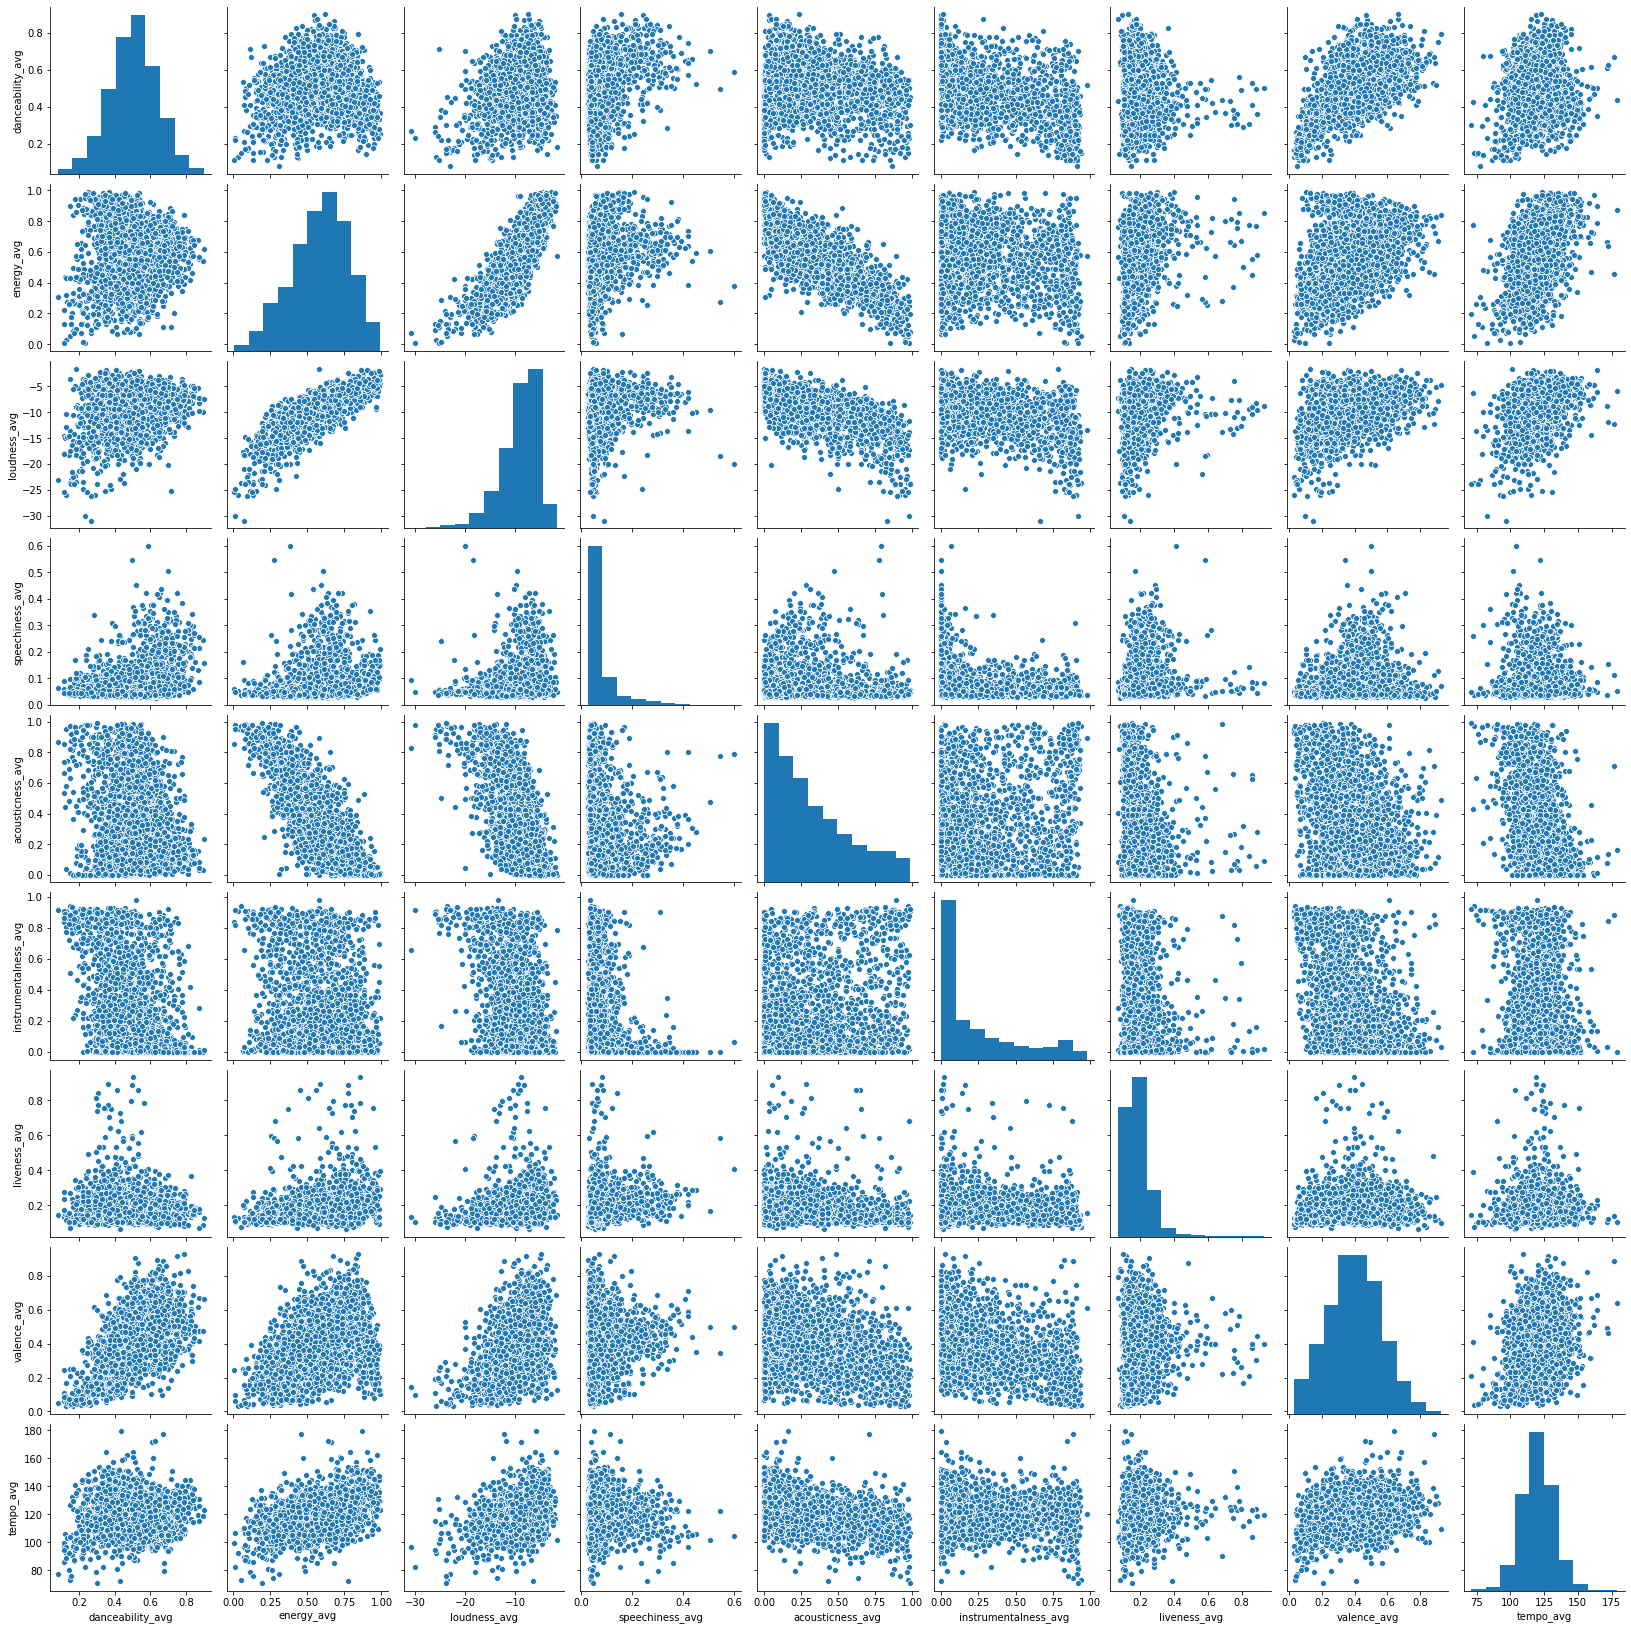

In [35]:
sns.pairplot(features[['danceability_avg', 'energy_avg', 'loudness_avg', 'speechiness_avg', 'acousticness_avg', 'instrumentalness_avg', \
                      'liveness_avg', 'valence_avg', 'tempo_avg']])

### Model preparation

Now I am going to split the data into train/test sets (stratified by the new "explicit category" variable to ensure each category is represented in both sets), and prepare an sk-learn Pipeline for additional model preparation steps so that they can quickly be broadcast to each separate dataframe.

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(features, features['explicit_cat']):
    strat_train_set = features.loc[train_index]
    strat_test_set = features.loc[test_index]

In [41]:
train_set = strat_train_set.copy()
train_set_labels = strat_train_set[['critic_score']].copy()

test_set = strat_test_set.copy()
test_set_labels = strat_test_set[['critic_score']].copy()

Identify columns with numerical attributes vs categorical attributes:

In [42]:
train_set_num = train_set.drop(columns=['release_month', 'day_of_week_release', 'explicit_cat'])
train_set_cat = train_set[['release_month', 'explicit_cat']]

test_set_num = train_set.drop(columns=['release_month', 'day_of_week_release', 'explicit_cat'])
test_set_cat = train_set[['release_month', 'explicit_cat']]

Create a class that will be used for any additional columns that will be a combination or transformation of a current column:  


In [43]:
energy_ix, acoustic_ix, length_ix, instrumental_ix = 7, 10, 3, 11
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_long_instrumentals = True):
        self.add_long_instrumentals = add_long_instrumentals
    def fit(self, X, y=None):
        return self #Nothing else to do
    def transform(self, X, y=None):
        X_vals = X.values
        energetic_acoustic = X_vals[:, acoustic_ix] - X_vals[:, energy_ix]
        if self.add_long_instrumentals:
            long_instrumentals = X_vals[:, length_ix] * X_vals[:, instrumental_ix]
            return np.c_[X_vals, energetic_acoustic, long_instrumentals]
        else:
            return np.c_[X_vals, energetic_acoustic]

The two attributes this class adds are just shown as examples, and I don't end up using them in the model.  In a future project, I would have used this space to add columns such as avg track length, log of monthly listeners, etc, so that they can be quickly reproduced for any dataframe

The numerical Pipeline acts only on the numerical attributes: 
- First it adds the attributes in the class we defined above
- Next, it invokes sklearn's standard scalar for feature scaling

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('attribute_adder', CombinedAttributesAdder(add_long_instrumentals=True)),
        ('standard_scaler', StandardScaler())
])

Finally we create a full pipeline, which consists of our numerical pipeline, which acts only on the numerical attributes, and a One Hot Encoder, which acts only on our categorical variables.  

The training set and test set can then be pushed through this pipeline to add additional attributes, scale all our features, and create dummy variables for all our categoricals, all by calling the pipeline's fit_transform method.

In [53]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
num_attribs = list(train_set_num)
cat_attribs = ['release_month', 'explicit_cat']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

train_set_pipeline = full_pipeline.fit_transform(train_set)


train_set_prepared = pd.DataFrame(data=train_set_pipeline, columns = num_attribs+ \
                                 ['energetic_acoustic', 'long_instrumentals', \
                                  'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', \
                                  'aug', 'sept', 'oct', 'nov', 'dec', 'none_explicit', \
                                 'some_explicit', 'all_explicit'])

In [54]:
train_set_prepared.drop(columns=['dec', 'all_explicit', 'percent_explicit', \
                                'energetic_acoustic', 'long_instrumentals', \
                                'album_length_seconds', 'energy_avg', 'valence_avg', \
                                'tempo_avg', 'instrumentalness_avg'], inplace=True)
train_set_prepared.drop(columns=['critic_score'], inplace=True)

### Model training and evaluation

Now that I've pushed my data through the full pipeline and prepared it for training, I took a look at the statsmodels OLS Regression as a first look at a linear regression model

In [55]:
import statsmodels.api as sm
X = train_set_prepared.copy()
y = train_set_labels.reset_index(drop=True)

In [56]:
model = sm.OLS(y, sm.add_constant(X))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           critic_score   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     10.87
Date:                Mon, 12 Oct 2020   Prob (F-statistic):           5.63e-36
Time:                        13:49:24   Log-Likelihood:                -6688.6
No. Observations:                1999   AIC:                         1.342e+04
Df Residuals:                    1976   BIC:                         1.355e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       73.4838      1.207     60.889      0.000      71.117      75.851
num_tracks                   1.0155      0.169      6.023      0.000       0.685       1.346
artist_monthly_listeners    -1.0049      0.194     -5.171      0.000      -1.386      -0.624
avg_track_length_seconds     0.4264      0.173      2.469      0.014       0.088       0.765
danceability_avg            -0.7540      0.189     -3.982      0.000      -1.125      -0.383
loudness_avg                -0.1415      0.235     -0.601      0.548      -0.603       0.320
speechiness_avg              0.3991      0.205      1.948      0.052      -0.003       0.801
acousticness_avg             1.0012      0.225      4.456      0.000       0.561       1.442
liveness_avg                 0.3669      0.174      2.111      0.035       0.026       0.708
log_monthly_listeners       -0.0963      0.207     -0.466      0.641      -0.501       0.309
jan                          0.8215      1.110      0.740      0.459      -1.355       2.998
feb                          0.1665      1.083      0.154      0.878      -1.958       2.291
mar                          2.3975      1.076      2.228      0.026       0.287       4.508
apr                          2.9233      1.058      2.764      0.006       0.849       4.998
may                          1.6791      1.057      1.589      0.112      -0.393       3.751
jun                          0.7018      1.062      0.661      0.509      -1.381       2.784
jul                          0.8174      1.087      0.752      0.452      -1.314       2.948
aug                          1.9646      1.026      1.915      0.056      -0.047       3.976
sept                         1.1121      1.014      1.097      0.273      -0.876       3.100
oct                          0.9844      1.054      0.934      0.351      -1.084       3.052
nov                         -0.3494      1.091     -0.320      0.749      -2.489       1.790
none_explicit                1.4273      0.861      1.658      0.097      -0.261       3.116
some_explicit                1.6134      0.837      1.927      0.054      -0.028       3.255
==============================================================================
Omnibus:                      133.667   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.002
Skew:                          -0.565   Prob(JB):                     9.09e-42
Kurtosis:                       3.996   Cond. No.                         34.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- None of our features have a P value above .9, and statsmodels would have warned us if there were any strong multicollinearities in our model, which is good
- However, our R^2 value of .111 is not a promising start, although not surprising since no one feature seemed to have a strong correlation with critic score

Let's also evaluate the training set and CV sets with scikit learn, to confirm that our model is experiencing bias issues

In [59]:
def lin_reg_scores(x, y):
    lin_reg = LinearRegression()
    lin_reg_fit = lin_reg.fit(x, y)
    print('Training set R^2:', lin_reg_fit.score(x, y))
    print('Cross Val R^2:', cross_val_score(lin_reg, x, y, cv=5))
    
lin_reg_scores(X, y)

Training set R^2: 0.1079854472294085
Cross Val R^2: [0.06204847 0.08720868 0.08213415 0.08574908 0.09147359]


Additionally, if our model was experiencing bias issues, we know that it would not improve as more training examples were added.  Let's visualize this by plotting a learning curve for the model, which shows us how the Mean Squared Error for the training set and CV set are changing as the model learns from each training example.

In [63]:
def plot_learning_curves(model, x, y):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
    train_errors, val_errors = [], []
    for m in range(1, len(x_train)):
        model.fit(x_train[:m], y_train[:m])
        y_train_predict = model.predict(x_train[:m])
        y_val_predict = model.predict(x_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    fig,ax=plt.subplots(figsize=(10,6))
    ax.set_xlabel('Number of Training Examples', fontsize=13)
    ax.set_ylabel('RMSE', fontsize=13, rotation='horizontal', labelpad=50)
    ax.annotate('Train', xy= [50, 4], xytext=[60, 3], color="#1798D8", fontweight='bold', fontsize=11)
    ax.annotate('Cross Val', xy = [60, 9], xytext=[60,9], color="#d85717", fontweight='bold', fontsize=11)
    ax.plot(np.sqrt(train_errors), color="#1798D8", linewidth=2, label="train")
    ax.plot(np.sqrt(val_errors), color="#d85717", linewidth=3, label="val")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,10)
    fig.suptitle('Learning Curve - Polynomial Features', fontsize=20, x = .125, y = 1.01, ha='left', fontweight='bold')
    ax.set_title('The model failing to improve after reaching 300 training examples \nshows that we are experiencing high bias', fontsize=13, color="#999999", fontweight='bold', loc='left')
    plt.savefig('learning_curve_2.png')

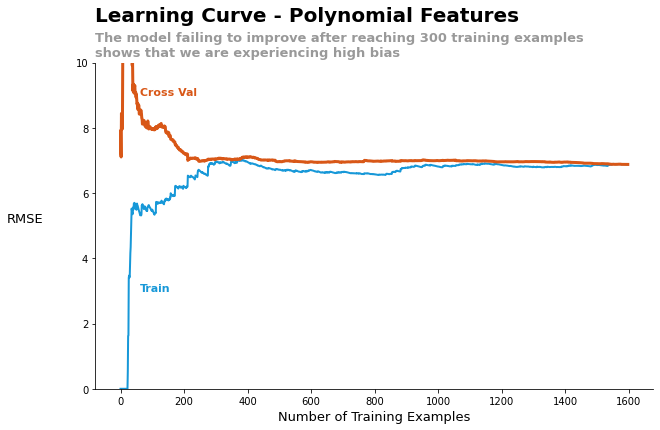

In [64]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

This confirms what we expected: there is some noise early on, but once we reach approximately 400 training examples, our model's training score stops improving.  

Plotting the residuals shows what our model is doing: 
- for albums with scores well above the mean, our guesses are too low
- for albums with scores well below the mean, our guesses are too high

We're not quite just guessing the mean score for every album, but it is still a similar behavior



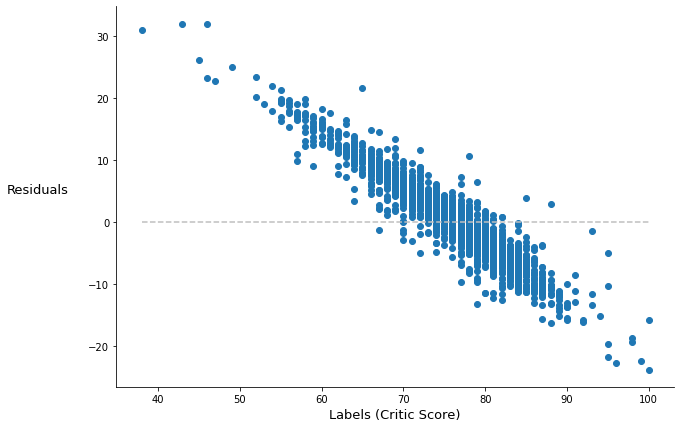

In [65]:
lin_reg = LinearRegression()
def plot_residuals(model, x, y):
    fit = model.fit(x,y)
    predictions = model.predict(x)
    residuals = predictions - y
    fig, ax = plt.subplots(figsize=(10,7))
    ax.scatter(y, residuals)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Labels (Critic Score)', fontsize=13)
    ax.set_ylabel('Residuals', fontsize=13, rotation='horizontal', labelpad=50)
    ax.plot([y.min(), y.max()], [0, 0], color = "#bfbfbf", linestyle='--')
    
plot_residuals(lin_reg, X, y)

Our options for fixing high bias are:
- getting additional features from other data sources that may be more predictive of critic score \
- Transforming existing features to try and bring out more linear relationships 
- Adding polynomial features and interaction features

First, let's try adding degree 2 polynomial/interaction features before we consider any more outside sources.  Since we already had 27 features to begin with, this will give us an enormous feature list, so we will need to regularize our model

In [70]:
def GetPolynomials(X, degree=2):
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    X_poly_df = pd.DataFrame(data=X_poly, columns = poly.get_feature_names(X.columns))
    return X_poly_df

X_poly = GetPolynomials(X, 2)

In [71]:
model = sm.OLS(y, X_poly)
fit = model.fit()
fit.summary()

/Users/vinnythompson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           critic_score   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     2.747
Date:                Mon, 12 Oct 2020   Prob (F-statistic):           6.33e-29
Time:                        13:52:49   Log-Likelihood:                -6528.6
No. Observations:                1999   AIC:                         1.347e+04
Df Residuals:                    1792   BIC:                         1.463e+04
Df Model:                         206                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
1                                                    73.6582      5.621     13.105      0.000      62.635      84.682
num_tracks                                           -2.2559      2.618     -0.862      0.389      -7.391       2.879
artist_monthly_listeners                             -5.4306      9.241     -0.588      0.557     -23.556      12.694
avg_track_length_seconds                             -1.6415      2.044     -0.803      0.422      -5.651       2.368
danceability_avg                                      0.4688      1.689      0.278      0.781      -2.843       3.781
loudness_avg                                         -4.6597      2.355     -1.979      0.048      -9.278      -0.041
speechiness_avg                                      -0.8477      1.435     -0.591      0.555      -3.662       1.966
acousticness_avg                                      1.9666      2.085      0.943      0.346      -2.123       6.056
liveness_avg                                          6.1941      1.661      3.728      0.000       2.936       9.453
log_monthly_listeners                                 0.2043      3.567      0.057      0.954      -6.792       7.201
jan                                                   1.9813      3.021      0.656      0.512      -3.943       7.906
feb                                                  -5.5368      2.631     -2.105      0.035     -10.696      -0.378
mar                                                   0.9073      2.702      0.336      0.737      -4.392       6.207
apr                                                   1.7623      2.687      0.656      0.512      -3.507       7.031
may                                                  -3.6270      2.479     -1.463      0.144      -8.489       1.235
jun                                                  -4.5665      3.116     -1.465      0.143     -10.678       1.545
jul                                                   1.3509      2.500      0.540      0.589      -3.553       6.255
aug                                                   0.3108      2.520      0.123      0.902      -4.632       5.253
sept                                                 -0.8037      2.434     -0.330      0.741      -5.577       3.970
oct                                                  -2.7128      2.634     -1.030      0.303      -7.879       2.453
nov                                                  -4.5309      2.732     -1.658      0.097      -9.890       0.828
none_explicit                                        -0.5335      2.546     -0.210      0.834      -5.526       4.459
some_explicit                                         1.9316      2.050      0.942      0.346      -2.089       5.952
num_tracks^2   

It's not particularly encouraging  that even with all these polynomial and interaction features, we could only muster an R^2 of .240- and that's before we even consider how badly this is overfitting before regularization. 

However, the takeaway may just be that critics are relatively agnostic to the features in our model, and that it's not worth trying to engineer your album to be something that you think will please a certain critic

In [73]:
def lin_reg_scores(x, y):
    lin_reg = LinearRegression()
    lin_reg_fit = lin_reg.fit(x, y)
    print('Training set R^2:', lin_reg_fit.score(x, y))
    print('Cross Val R^2:', cross_val_score(lin_reg, x, y, cv=5))
    
lin_reg_scores(X_poly, y)

Training set R^2: 0.2399643060324944
Cross Val R^2: [-0.1148832  -0.02118213 -0.11059869 -0.22909488 -0.02674804]


Ouch. To hammer the point home that we are overfitting with all these extra 2nd degree features, here's a look at the learning curve for this regression model before applying regularization. 

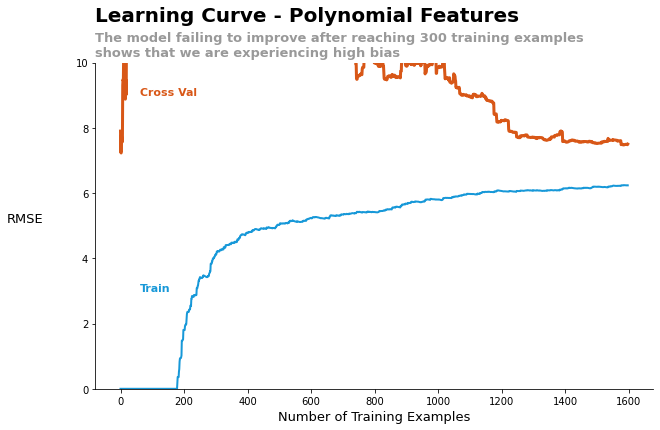

In [74]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X_poly, y)

The train error and CV are much further apart, even as they seem to be leveling out.  It's *possible* just looking at this graph that our CV error would continue drop a little more if we had a larger training set, but we're still badly overfitting the data.

We can will use Lasso CV for regularization, which will be preferrable because now that our set of features is so large, we will likely want to set a large portion of coefficients to 0, and hope that features we keep are more predictive than our original model

In [81]:
def lasso_CV_score(x, y, alphas, coefs=False):
    reg = LassoCV(cv=5, random_state=10, alphas = alphas, max_iter=3000).fit(x,y)
    print("Best alpha: ", reg.alpha_)
    if coefs:
        print('# of coefs reduced to 0: ', sum([True if coef == 0 else False for coef in reg.coef_]))
        print('# of nonzero coefs: ', sum([True if coef > 0 else False for coef in reg.coef_]))

In [82]:
lasso_CV_score(X_poly, y.values.reshape(-1, ), alphas = [.1, 1, 10, 100], coefs=True)

Best alpha:  0.1
# of coefs reduced to 0:  241
# of nonzero coefs:  20


Let's now make one more pass through a list alphas closer to 0.1:

In [83]:
alphas = [0.01, 0.02, 0.04, 0.08, .10, .15, .18, .2, .25, .3, .4]
lasso_CV_score(X_poly, y.values.reshape(-1, ), alphas = alphas, coefs=True)

Best alpha:  0.1
# of coefs reduced to 0:  241
# of nonzero coefs:  20


We'll stop here and use 0.1 as our regularization hyperparameter.  Notice how an increase in regularization strength eliminates a significant amount of coefficients.  An alpha of 5 would have left us with just one nonzero coefficient in our model:

In [84]:
alphas = [1]
lasso_CV_score(X_poly, y.values.reshape(-1, ), alphas = alphas, coefs=True)
alphas = [5]
lasso_CV_score(X_poly, y.values.reshape(-1, ), alphas = alphas, coefs=True)

Best alpha:  1
# of coefs reduced to 0:  270
# of nonzero coefs:  4
Best alpha:  5
# of coefs reduced to 0:  275
# of nonzero coefs:  1


Finally, let's prepare our fully regularized model and see how we do:

In [85]:
x_train, x_val, y_train, y_val = train_test_split(X_poly, y, test_size=0.2, random_state=50)

lasso = Lasso(alpha=0.2)
lasso.fit(x_train, y_train)

# score fit model on validation data
val_score = lasso.score(x_val, y_val)
# score train data
train_score = lasso.score(x_train, y_train)


print('Training set R^2:', train_score)
print('Cross Val R^2:', val_score)

Training set R^2: 0.1168470100419079
Cross Val R^2: 0.11667964397821884


So overall, we did a little better by adding polynomial features and regularizing, but not enough that our model was successful at predicting critic scores.

Since we've come this far, lets bring in our test set, running it through our pipeline and checking how the model does on the data it hasn't seen

In [98]:
test_set_pipeline = full_pipeline.fit_transform(test_set)
test_set_prepared = pd.DataFrame(data=test_set_pipeline, columns = num_attribs+ \
                                 ['energetic_acoustic', 'long_instrumentals', \
                                  'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', \
                                  'aug', 'sept', 'oct', 'nov', 'dec', 'none_explicit', \
                                 'some_explicit', 'all_explicit'])
test_set_prepared.drop(columns=['dec', 'all_explicit', 'percent_explicit', \
                                'energetic_acoustic', 'long_instrumentals', \
                                'album_length_seconds', 'energy_avg', 'valence_avg', \
                                'tempo_avg', 'instrumentalness_avg'], inplace=True)
test_set_prepared.drop(columns=['critic_score'], inplace=True)

X_test = GetPolynomials(test_set_prepared.copy(), degree=2)
y_test = test_set_labels.reset_index(drop=True)

In [100]:
test_score = lasso.score(X_test, y_test)
test_score

0.08835802935114234

In [101]:
test_predictions = lasso.predict(X_test)
test_residuals = test_predictions - y_test.critic_score

(65.0, 95.0)

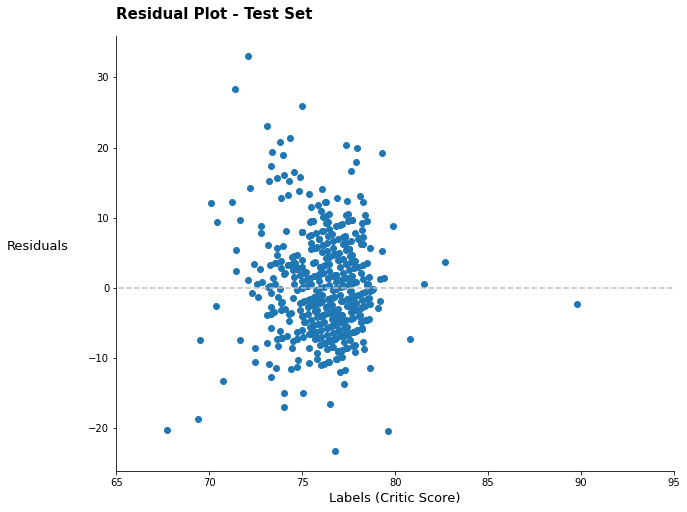

In [102]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(test_predictions, test_residuals)
ax.plot([y.min(), y.max()], [0, 0], color = "#bfbfbf", linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Labels (Critic Score)', fontsize=13)
ax.set_ylabel('Residuals', fontsize=13, rotation='horizontal', labelpad=50);
fig.suptitle('Residual Plot - Test Set', fontsize=15, x=.125, ha='left',y=.93, fontweight="bold")
ax.set_xlim(65, 95)

Looking at the residuals on the test, it's clear that our model is still too biased.  Since no feature really has a strong enough correlation, the safest thing for it to do is just stay somewhere around the mean and adjust slightly based on the features in the model.  

In [103]:
print("Mean:" ,"%.2f" % (np.mean(test_predictions)), \
      "\nSt Dev:", "%.2f" %(np.std(test_predictions)))

Mean: 76.12 
St Dev: 1.93


In [104]:
print("Mean:" ,"%.2f" % (np.mean(y_test.critic_score)), \
      "\nSt Dev:", "%.2f" %(np.std(y_test.critic_score)))

Mean: 75.89 
St Dev: 7.78


On average, our guess is close to the test set mean, but the model is not nearly sensitive enough to variation in the data